In [10]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import ElasticNet, Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
import matplotlib.pyplot as plt

In [ ]:
def loadtextmetrics(file, columns=[], keyword=[]):
    dftext = pd.read_csv(file, index_col=[0])
    dftext['date'] = pd.to_datetime(dftext['date'])
    dftext = dftext[(dftext.keyword in keyword)]
    return dftext

In [ ]:
loadtextmetrics(file='philippines tweets_monthly-230101.csv', columns=['date', 'keyword', 'TBweight_cl2rt'])

# Load GDP data

In [11]:
gdpDF = pd.read_csv('ph-gdp.csv').rename(columns={'Unnamed: 0': 'date'})
gdpDF['date'] = pd.to_datetime(gdpDF['date'])
gdpDF = gdpDF.set_index('date')
gdpDF = gdpDF.resample('M').first().reset_index()
gdpDF = gdpDF.bfill()
gdpDF = gdpDF[gdpDF['date']>'2006'].reset_index(drop=True)
gdpDF

,date,gdpg
0,2006-01-31,4.501934
1,2006-02-28,4.501934
2,2006-03-31,4.501934
3,2006-04-30,5.919070
4,2006-05-31,5.919070
...,...,...
199,2022-08-31,7.635937
200,2022-09-30,7.635937
201,2022-10-31,7.225544
202,2022-11-30,7.225544


## Load Text Metrics

In [38]:
# dftext = pd.read_csv("Data/Model Input Data/philippines tweets_monthly-230101.csv", index_col=[0])
dftext = pd.read_csv("philippines tweets_monthly-230101.csv", index_col=[0])
dftext['date'] = pd.to_datetime(dftext['date'])
# dftext = dftext[(dftext.keyword == 'PE')]
dftext = dftext[['date', 'keyword', 'TBweight_cl2rt', 'VADERweight_cl2rt']]
dftext

,date,keyword,TBweight_cl2rt,VADERweight_cl2rt
0,2007-11-30,PE,0.131250,0.108700
1,2007-12-31,PE,-0.500000,0.100700
2,2008-01-31,PE,0.200000,-0.089467
3,2008-02-29,PE,0.000000,0.000000
4,2008-03-31,PE,0.123190,0.112400
...,...,...,...,...
344,2022-08-31,PU+,17.829925,-115.883196
345,2022-09-30,PU+,1.221688,-3.138205
346,2022-10-31,PU+,0.828685,-1.298904
347,2022-11-30,PU+,100.607905,116.582976


## Merge Text Metrics with GDP Data

In [40]:
df = pd.merge(dftext, gdpDF, how='inner', on='date')
# df.drop(columns=['keyword', 'tweet_count', 'tweet_normalized', 'CL', 'CR', 'CL1RT', 'CL2RT'], inplace=True)
df.drop(columns=['keyword'], inplace=True)
df.dropna(axis=0, inplace=True)
df.set_index('date', inplace=True)
df = df.loc[dt.datetime(2009,10,1):,:]
df

,TBweight_cl2rt,VADERweight_cl2rt,gdpg
date,,,
2009-10-31,0.108948,0.012513,1.783833
2009-10-31,-0.028079,-0.088407,1.783833
2009-11-30,0.058485,0.126080,1.783833
2009-11-30,-0.016667,-0.467167,1.783833
2009-12-31,0.142465,0.009217,1.783833
...,...,...,...
2022-10-31,0.828685,-1.298904,7.225544
2022-11-30,3.128461,17.724961,7.225544
2022-11-30,100.607905,116.582976,7.225544


In [ ]:
dfpe = dftext[dftext['keyword'] == 'PE'].drop(columns=['keyword']).add_suffix('_PE')
dfpu = dftext[dftext['keyword'] == 'PU+'].drop(columns=['keyword']).add_suffix('_PU')
pd.merge(dfpe, dfpu, on='date', how='outer')
pd.concat

## Add Lags

In [14]:
dff = pd.concat([df.shift(l).add_suffix(f'.L{l}') for l in range(4)], axis=1).drop(columns=['gdpg.L1', 'gdpg.L2']).rename(columns={'gdpg.L0':'gdpg'})
dff = dff.drop(columns=[col for col in dff.columns if ('L3' in col and col != 'gdpg.L3')])
dff = dff.reset_index(drop=False).dropna()
dff = dff.loc[dff.date.dt.month%3 == 0, :]
dff

,date,TBraw_ave.L0,TBpolar_ave.L0,TBneg_ave.L0,TBpos_ave.L0,TBweight_cl2rt.L0,VADERraw_ave.L0,VADERpolar_ave.L0,VADERneg_ave.L0,VADERpos_ave.L0,...,TBpolar_ave.L2,TBneg_ave.L2,TBpos_ave.L2,TBweight_cl2rt.L2,VADERraw_ave.L2,VADERpolar_ave.L2,VADERneg_ave.L2,VADERpos_ave.L2,VADERweight_cl2rt.L2,gdpg.L3
5,2010-03-31,0.122338,0.276228,-0.309127,0.238319,0.130907,0.158517,0.288734,-0.459481,0.453696,...,0.184789,-0.251452,0.214408,0.081549,0.102490,0.233731,-0.383764,0.443174,0.111081,1.783833
8,2010-06-30,0.110779,0.272634,-0.178322,0.217305,0.123955,0.109352,0.199469,-0.412344,0.478738,...,0.343240,-0.301872,0.242048,0.178576,0.213930,0.375294,-0.427803,0.603889,0.235274,8.120349
11,2010-09-30,0.117525,0.281563,-0.226473,0.236986,0.132713,0.109077,0.198628,-0.443122,0.470938,...,0.047162,-0.330127,0.205703,0.053291,0.189046,0.356376,-0.449498,0.515827,0.194200,7.974927
14,2010-12-31,0.099135,0.281334,-0.170486,0.219016,0.116058,0.143372,0.254519,-0.500558,0.457778,...,0.315135,-0.203882,0.253599,0.081056,0.131073,0.247394,-0.407227,0.460191,0.125972,7.069163
17,2011-03-31,0.110388,0.268061,-0.189418,0.225609,0.162317,0.117187,0.225562,-0.449651,0.445159,...,0.248155,-0.184594,0.217527,0.132619,0.165652,0.337007,-0.334819,0.438407,0.281859,6.298936
20,2011-06-30,0.096578,0.258856,-0.196716,0.226946,0.133699,0.116978,0.198247,-0.462572,0.492524,...,0.309561,-0.191316,0.209554,0.133775,0.109969,0.206002,-0.413904,0.461573,0.143567,4.827017
23,2011-09-30,0.089282,0.279270,-0.177019,0.235527,0.186161,0.057972,0.104254,-0.447665,0.458723,...,0.367017,-0.199792,0.264302,0.240470,0.165430,0.310516,-0.451145,0.499281,0.402476,3.560325
26,2011-12-31,0.108050,0.340075,-0.195074,0.302180,0.167942,0.121629,0.208486,-0.355169,0.442713,...,0.212375,-0.264075,0.216423,0.103518,0.101320,0.224221,-0.426498,0.435475,0.135080,3.035778
29,2012-03-31,0.090517,0.362305,-0.179016,0.248793,0.165878,0.136566,0.290127,-0.394811,0.468651,...,0.318275,-0.199766,0.281869,0.184773,0.151316,0.316549,-0.330508,0.464024,0.220236,4.034918
32,2012-06-30,0.116472,0.346106,-0.220666,0.304013,0.438434,0.169437,0.306758,-0.436006,0.504049,...,0.258170,-0.201320,0.245388,0.243983,0.109751,0.222381,-0.408030,0.441185,0.416958,6.040021


# ElasticNet vs AR
## ElasticNet (Philippines)

In [15]:
regr = ElasticNet()

regr.fit(dff.drop(columns=['gdpg', 'date']).to_numpy(), dff.gdpg.to_numpy())

ElasticNet()

In [16]:
for coeff, var in zip(regr.coef_, dff.columns.drop(['date', 'gdpg'])):
    print(var, coeff)

TBraw_ave.L0 0.0
TBpolar_ave.L0 0.0
TBneg_ave.L0 -0.0
TBpos_ave.L0 0.0
TBweight_cl2rt.L0 0.7000663397106202
VADERraw_ave.L0 0.0
VADERpolar_ave.L0 0.0
VADERneg_ave.L0 0.0
VADERpos_ave.L0 -0.0
VADERweight_cl2rt.L0 -0.0936597628604039
TBraw_ave.L1 0.0
TBpolar_ave.L1 0.0
TBneg_ave.L1 0.0
TBpos_ave.L1 0.0
TBweight_cl2rt.L1 -0.6920532710028444
VADERraw_ave.L1 0.0
VADERpolar_ave.L1 0.0
VADERneg_ave.L1 0.0
VADERpos_ave.L1 -0.0
VADERweight_cl2rt.L1 0.04653055426999979
TBraw_ave.L2 0.0
TBpolar_ave.L2 0.0
TBneg_ave.L2 -0.0
TBpos_ave.L2 0.0
TBweight_cl2rt.L2 -0.0
VADERraw_ave.L2 0.0
VADERpolar_ave.L2 0.0
VADERneg_ave.L2 0.0
VADERpos_ave.L2 -0.0
VADERweight_cl2rt.L2 -0.04648456285166903
gdpg.L3 0.8865538087017065


In [17]:
regr.score(dff.drop(columns=['gdpg', 'date']).to_numpy(), dff.gdpg.to_numpy())

0.7743608909901853

In [18]:
mean_squared_error(dff.gdpg.to_numpy(), regr.predict(dff.drop(columns=['gdpg', 'date']).to_numpy()))

5.440574487552127

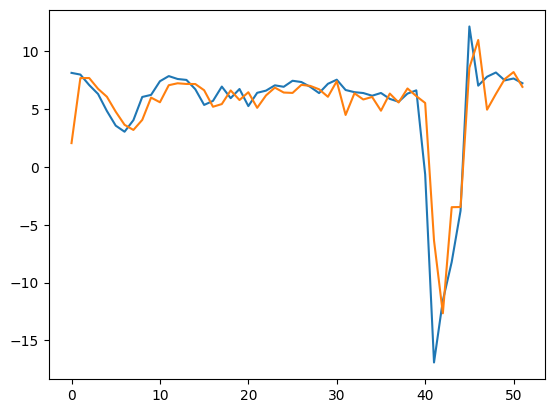

In [19]:
plt.plot(dff.gdpg.to_numpy())
plt.plot(regr.predict(dff.drop(columns=['gdpg', 'date']).to_numpy()))

## AR (Philippines)

In [20]:
# AR(1) with itself only
mod = AutoReg(dff.gdpg, lags=1).fit()
np.power(mod.resid, 2).mean()

/Users/btiu/Documents/Tweets/Trial/tweets_dashboard/dashboard/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


11.5335719186652

In [21]:
# AR(1) with the weighted sentiments
mod = AutoReg(dff.gdpg.reset_index(drop=True), lags=1, exog=dff[['TBweight_cl2rt.L0', 'TBweight_cl2rt.L1', 'TBweight_cl2rt.L2', 'VADERweight_cl2rt.L0', 'VADERweight_cl2rt.L1', 'VADERweight_cl2rt.L2']].reset_index(drop=True)).fit()
np.power(mod.resid, 2).mean()

3.7722301314145272

In [22]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                   gdpg   No. Observations:                   52
Model:                   AutoReg-X(1)   Log Likelihood                -106.221
Method:               Conditional MLE   S.D. of innovations              1.942
Date:                Tue, 07 Mar 2023   AIC                            230.443
Time:                        18:15:11   BIC                            247.829
Sample:                             1   HQIC                           237.087
                                   52                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.4059      0.461     -0.881      0.378      -1.309       0.497
gdpg.L1                  1.0531      0.067     15.651      0.000       0.921       1.185
TBweight_cl2rt.L0        1.1191      0.149      7.499      0.000       0.827       1.412
TBweight_cl2rt.L1       -1.0484      0.168     -6.240      0.000      -1.378      -0.719
TBweight_cl2rt.L2        0.1725      0.310      0.556      0.578      -0.435       0.780
VADERweight_cl2rt.L0    -0.2635      0.103     -2.551      0.011      -0.466      -0.061
VADERweight_cl2rt.L1     0.0395      0.072      0.550      0.583      -0.101       0.180
VADERweight_cl2rt.L2    -0.2263      0.191     -1.184      0.236      -0.601       0.148
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9496           +0.0000j            0.9496            0.0000
-----------------------------------------------------------------------------
"""

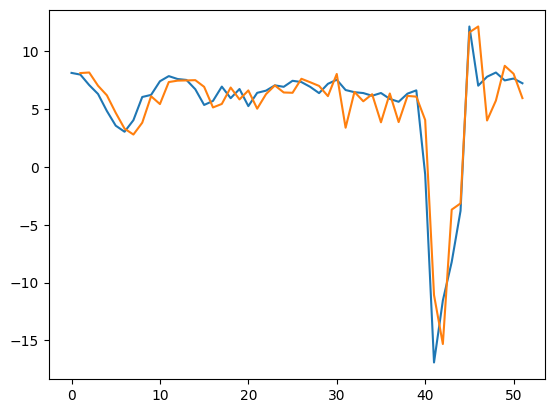

In [23]:
plt.plot(dff.gdpg.to_numpy())
plt.plot(mod.predict(start=0, end=51))

# Output to comparison dataframe

In [24]:
# Filter and set date as index for plotting
gdpDFplot = gdpDF[(gdpDF['date'].dt.year > 2009)]
gdpDFplot = gdpDFplot.set_index('date')
gdpDFplot

,gdpg
date,
2010-01-31,8.120349
2010-02-28,8.120349
2010-03-31,8.120349
2010-04-30,7.974927
2010-05-31,7.974927
...,...
2022-08-31,7.635937
2022-09-30,7.635937
2022-10-31,7.225544


In [25]:
### Add Elastic Net predictions
# Set Date Index to compare with ADB predictions by date
outputDF = dff.reset_index(drop=True)[['date']]
outputDF['ENetPred'] = regr.predict(dff.drop(columns=['gdpg', 'date']))
# outputDF

/Users/btiu/Documents/Tweets/Trial/tweets_dashboard/dashboard/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


In [26]:
### Add the AR(1) predictions
# Set Date Index to compare with ADB predictions by date
outputDF['AR1Pred'] = mod.predict(start=0, end=51)
outputDF = outputDF.set_index('date')
outputDF.head(5).append(outputDF.tail(5))

/var/folders/xt/bhvzcd8528z9rmqsj7n4_2hr0000gp/T/ipykernel_11844/4108293890.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outputDF.head(5).append(outputDF.tail(5))


,ENetPred,AR1Pred
date,,
2010-03-31,2.051396,NaN
2010-06-30,7.669393,8.107178
2010-09-30,7.676129,8.156747
2010-12-31,6.745160,7.011479
2011-03-31,6.059081,6.182763
2021-12-31,4.941666,4.008073
2022-03-31,6.300533,5.728639
2022-06-30,7.587072,8.735097
2022-09-30,8.191807,8.045091


In [27]:
adbDF = pd.read_csv('adb-gdp.csv').rename(columns={'Unnamed: 0': 'date'})
adbDF['date'] = pd.to_datetime(adbDF['date'])
adbDF = adbDF.set_index('date')
adbDF.dropna(inplace=True)
adbDF

,in,my,ph,sg,th,vn
date,,,,,,
2010-03-31,5.5,5.3,3.8,6.3,4.0,6.5
2010-09-30,6.1,6.8,6.2,14.0,7.0,6.7
2011-03-31,6.4,5.3,5.0,5.5,4.5,6.1
2011-09-30,6.6,4.8,4.7,5.5,4.0,5.8
2012-03-31,6.4,4.0,4.8,2.8,5.5,5.7
2012-09-30,6.3,4.6,5.5,2.2,5.2,5.1
2013-03-31,6.4,5.3,6.0,2.6,4.9,5.2
2013-09-30,5.7,4.3,7.0,2.6,3.8,5.2
2014-03-31,5.7,5.1,6.4,3.9,2.9,5.6


In [28]:
outputDF = pd.merge(outputDF, gdpDFplot, on='date', how='left')
outputDF = pd.merge(outputDF, adbDF[['ph']], on='date', how='outer')
outputDF.rename(columns={'ph':'adb'}, inplace=True)
outputDF['ENet_err'] = abs(outputDF['gdpg'] - outputDF['ENetPred'])
outputDF['AR1_err'] = abs(outputDF['gdpg'] - outputDF['AR1Pred'])
outputDF['ADB_err'] = abs(outputDF['gdpg'] - outputDF['adb'])
outputDF[['gdpg', 'ENetPred', 'ENet_err', 'AR1Pred', 'AR1_err', 'adb', 'ADB_err']]

,gdpg,ENetPred,ENet_err,AR1Pred,AR1_err,adb,ADB_err
date,,,,,,,
2010-03-31,8.120349,2.051396,6.068953,NaN,NaN,3.8,4.320349
2010-06-30,7.974927,7.669393,0.305534,8.107178,0.132251,NaN,NaN
2010-09-30,7.069163,7.676129,0.606966,8.156747,1.087584,6.2,0.869163
2010-12-31,6.298936,6.745160,0.446223,7.011479,0.712543,NaN,NaN
2011-03-31,4.827017,6.059081,1.232064,6.182763,1.355745,5.0,0.172983
2011-06-30,3.560325,4.765846,1.205521,4.669544,1.109219,NaN,NaN
2011-09-30,3.035778,3.632175,0.596397,3.302046,0.266268,4.7,1.664222
2011-12-31,4.034918,3.189520,0.845399,2.794012,1.240906,NaN,NaN
2012-03-31,6.040021,4.057806,1.982215,3.817565,2.222456,4.8,1.240021


In [29]:
print(f'Elastic Net MAE: {outputDF["ENet_err"].mean()}')
print(f'AR(1) MAE: {outputDF["AR1_err"].mean()}')
print(f'ADB MAE: {outputDF["ADB_err"].mean()}')

Elastic Net MAE: 1.3613233700520861
AR(1) MAE: 1.3419910820030896
ADB MAE: 1.645770226976744


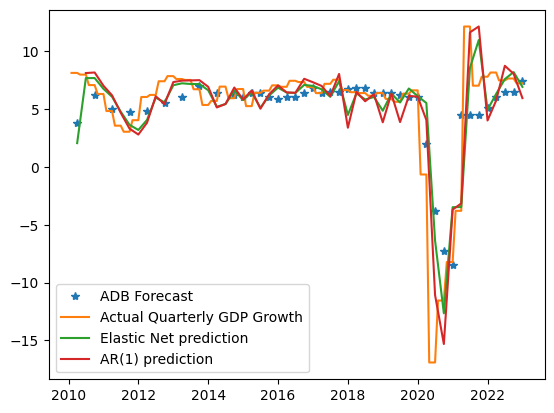

In [30]:
plt.plot(adbDF['ph'], label='ADB Forecast', linewidth=0, marker='*')
plt.plot(gdpDFplot['gdpg'], label='Actual Quarterly GDP Growth')
plt.plot(outputDF['ENetPred'], label='Elastic Net prediction')
plt.plot(outputDF['AR1Pred'], label='AR(1) prediction')
plt.legend(loc="lower left")